<a href="https://colab.research.google.com/github/ChrizZhuang/memtransistor_NLP/blob/main/RNN_4_terminals_memtransistor_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RNN Simulation of Dual gates 4 terminals memtransistor**

**Hardware paper**

- *Dual-Gated MoS2 Memtransistor Crossbar Array* https://onlinelibrary.wiley.com/doi/abs/10.1002/adfm.202003683

**Hardware code with the application of CV**

- https://colab.research.google.com/drive/1_zY4qp1u8IZhc_ht4t-iHr2m53j7u2li

**RNN Algorithm for sentiment analysis**

- https://www.tensorflow.org/text/tutorials/text_classification_rnn

### **Import modules**

In [1]:
# uses tensorflow v2.7.0
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os

tfds.disable_progress_bar()
print(tf.__version__)

2.7.0


In [3]:
# mount to google drive to save model and weights
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Parse in devise states**
! Should include the *learning_curve_vinod.csv* file in the directory

In [2]:
# imports data from single column CSV file with possible current/conductance states
# return numpy array of approximate states possible using this hardware
# this import method is not generalized, but fine-tuned to Vinod's devices
def import_data_from_csv(filename):
  # import data
  imported_device_states = np.genfromtxt(filename, delimiter=',')[1:]

  # since data is in ~1 nA, assume maximum precision is ~1 pA
  # this will make some states redundant
  imported_device_states = np.unique(np.round(np.sort(imported_device_states), decimals=3))

  # calculate device states possible
  device_states = np.array([])
  for i, value in enumerate(imported_device_states):
      if i+1 > len(imported_device_states):
          break
      temp_ls = value - imported_device_states
      device_states = np.append(device_states, temp_ls)


  # normalize to -1 to 1
  device_states = np.unique(np.sort(device_states))
  device_states = device_states / np.abs(device_states).max()

  # given the large number of states, we can assume some states are almost equivalent
  # moreover, once the number of states is > 100, the discreteness doesnt matter
  # for simplicity in the simulations, we will simply  round to 2 digits of the calculated states
  device_states = np.round(device_states, decimals = 2)
  device_states = np.unique(np.sort(device_states))
  
  return device_states

###**Define global constants**

In [ ]:
# for device
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learning_curve_vinod.csv')

READ_NOISE_MEAN = 0
READ_NOISE_STDDEV = 0.1

DEVICE_VARIATION_STDDEV = 0.1

DEVICE_STUCK_ON_PROB = 0.1
DEVICE_STUCK_OFF_PROB = 0.1

In [ ]:
# for RNN model and training
NUM_EPOCHS = 10
BUFFER_SIZE = 10000
BATCH_SIZE = 64

###**Load and preprocess data**

In [ ]:
# load data
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

# shuffle the train set
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# data example
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'When this movie was first shown on television I had high hopes that we would finally have a decent movie about World War I as experienced by American soldiers. Unfortunately this is not it.<br /><br />It should have been a good movie about WWI. Even though it was made for television it is obvious that a real effort was made to use appropriate equipment and props. But the writing and directing are badly lacking, even though the makers of this movie obviously borrowed freely from quite a few well made war movies. War movie clich\xc3\xa9s abound such as the arrogant general who apparently does not care a flip about the lives of his men. When will Hollywood realize that, even though there have been plenty of bad generals, most combat unit generals have seen plenty of combat themselves and are not naive about what the average grunt experiences? The first part of this movie appeared to be "Paths of Glory" with American uniforms. Except that "Paths of Glory" was emotionally grippin

### **Create the text encodert**
The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
VOCAB_SIZE = 1000
# Maximum size of the vocabulary for this layer. 
# This should only be specified when adapting a vocabulary or when setting pad_to_max_tokens=True. 
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, name = 'encoder')
# adapt: Fits the state of the preprocessing layer to the data being passed.
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary()) # len(vocab) = 1000 as VOCAB_SIZE = 1000

###**Build the model and get the weights**

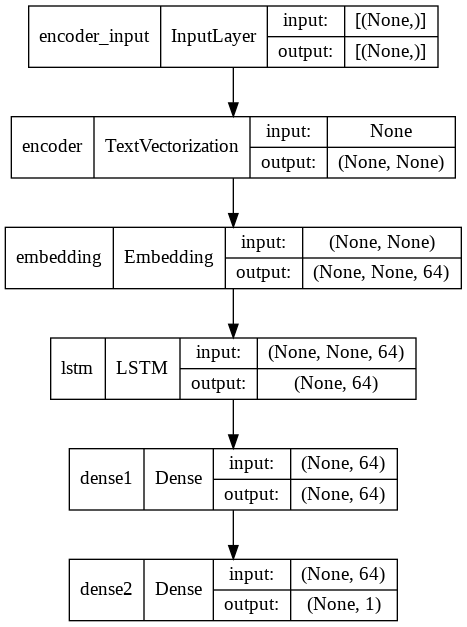

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        name='embedding',
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64, name='lstm'),
    tf.keras.layers.Dense(64, activation='relu', name='dense1'),
    tf.keras.layers.Dense(1, name='dense2')
])

#print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# 1. keras.layers.preprocessing.index_lookup.VocabWeightHandler
# 2. 'embedding/embeddings:0' shape=(1000, 64)
# 3. 'lstm/lstm_cell/kernel:0' shape=(64, 256)
# 4. 'lstm/lstm_cell/recurrent_kernel:0' shape=(64, 256)
# 5. 'lstm/lstm_cell/bias:0' shape=(256,)
# 6. 'dense/kernel:0' shape=(64, 64)
# 7. 'dense/bias:0' shape=(64,)
# 8. 'dense_1/kernel:0' shape=(64, 1)
# 9. 'dense_1/bias:0' shape=(1,)
model_weights = model.trainable_variables # len(weights) = 8

###**Gradient update scheme of memtransistor**

In [ ]:
g_min_value = np.min(np.abs(DEVICE_STATES))
g_max_value = np.max(np.abs(DEVICE_STATES))
    
# to make this notebook's output stable across runs
def reset_graph(seed=42):
  tf.random.set_seed(seed)
  np.random.seed(seed)

# will create matrix to simulate device-to-device variation by creating clipping the weights
# will also simulate devices being stuck-on-open and stuck-on-close 
def initialize_variation_stuck_mat(shape):
  # VARIATION
  wp_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is smaller than 1
  wp_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is larger than 0

  wm_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is smaller than 1
  wm_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is larger than 0

  # STUCK
  stuck_prob = [DEVICE_STUCK_OFF_PROB, 1 - DEVICE_STUCK_ON_PROB - DEVICE_STUCK_OFF_PROB, DEVICE_STUCK_ON_PROB]
  w_p_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob) 
  w_m_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob)

  # if device is stuck OFF
  wp_max = wp_max + (w_p_stuck == -1) * (wp_min - wp_max)
  wm_max = wm_max + (w_m_stuck == -1) * (wm_min - wm_max)

  # if device is stuck ON
  wp_min = wp_min + (w_p_stuck == 1) * (wp_max - wp_min)
  wm_min = wm_min + (w_m_stuck == 1) * (wm_max - wm_min)


  # PUTTING TOGETHER CLIPPING MATRIX
  # numpy.clip(a, a_min, a_max) 
  # Clip (limit) the values in an array.
  # Given an interval, values outside the interval are clipped to the interval edges
  lower_lim = np.clip(wp_min - wm_max, -g_max_value, -g_min_value)
  upper_lim = np.clip(wp_max - wm_min, g_min_value, g_max_value)

  #print('Lower lim: ' + str(lower_lim))
  #print('Upper lim: ' + str(upper_lim))

  return [lower_lim, upper_lim]

# weight update with a discrete number of states and (optional) add read noise
def discrete_weight_update(value, read_noise_mean=0, read_noise_stddev=0):
    if read_noise_stddev != 0:
        value += np.random.normal(read_noise_mean, read_noise_stddev)
    absolute_difference_function = lambda list_value : abs(list_value - value)
    return min(DEVICE_STATES, key=absolute_difference_function)
v_discrete_weight_update = np.vectorize(discrete_weight_update)

# function puts together all the parts
# 1. Device variation
# 2. Stuck-on/off 
# 3. Discrete number of weight states
# Input = software weights matrix, Output = hardware weights matrix
def simulate_hardware_weight_update(weights_mat, var_stuck_mat):

  # initialize variation and stuck matrix if not initialized
  if type(weights_mat) is not np.array:
    weights_mat = np.array(weights_mat)

  if type(var_stuck_mat) is not np.ndarray:
      var_stuck_mat = initialize_variation_stuck_mat(weights_mat.shape)

  # simulate weight variation and stuck on open/close
  weights_mat = weights_mat.clip(var_stuck_mat[0], var_stuck_mat[1])

  # simulate discrete states
  weights_mat = v_discrete_weight_update(weights_mat, read_noise_mean = READ_NOISE_MEAN,
                        read_noise_stddev = READ_NOISE_STDDEV)

  return weights_mat

###**Train the model**

In [ ]:
# reset default tf graph before running sim
reset_graph()

# define weight update ops
var_stuck_mat = [False, False, False, False, False, False, False, False]
weights = np.zeros([1, 8])[0].tolist()
new_weights = np.zeros([1, 8])[0].tolist()
weight_update_op = np.zeros([1, 8])[0].tolist()
weight_layers = ["embedding/embeddings:0", "lstm/lstm_cell/kernel:0", "lstm/lstm_cell/recurrent_kernel:0", "lstm/lstm_cell/bias:0",
          "dense1/kernel:0", "dense1/bias:0", "dense2/kernel:0", "dense2/bias:0"]

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=1,
            validation_data=test_dataset,
            validation_steps=30)

391/391 [==============================] - 301s 755ms/step - loss: 0.6451 - accuracy: 0.5673 - val_loss: 0.4956 - val_accuracy: 0.7458


In [ ]:
history.history

{'accuracy': [0.5673199892044067],
 'loss': [0.645052433013916],
 'val_accuracy': [0.7458333373069763],
 'val_loss': [0.49558401107788086]}

In [ ]:
new_weights = []
for i, weight in enumerate(model.trainable_variables):
  new_weights.append(simulate_hardware_weight_update(weight, var_stuck_mat[i]))

In [ ]:
# update the model weights
model.layers[1].set_weights([new_weights[0]])
model.layers[2].set_weights([new_weights[1], new_weights[2], new_weights[3]])
model.layers[3].set_weights([new_weights[4], new_weights[5]])
model.layers[4].set_weights([new_weights[6], new_weights[7]])
#model.trainable_variables

In [ ]:
#for example, label in test_dataset.take(1):
  #print('texts: ', example.numpy()[:3])
  #print()
  #print('labels: ', label.numpy()[:3])
  #print()
  #print('preds: ', type(model.predict(example.numpy()[:3])))

labels:  [1 1 0]

preds:  <class 'numpy.ndarray'>


###**Construct the final function**

In [4]:
def run_RNN_simulation(save_results_input=False,
            num_epochs_input=50, 
            hardware_simulation_input=False, 
            device_states_input=False,
            read_noise_mean_input=0,
            read_noise_stddev_input=0,
            device_variation_stddev_input=0,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0):
  
  ###################### USER DEFINED PARAMETERS FOR SIMULATION
  # whether or not to save results
  SAVE_RESULTS = save_results_input
  
  # number of epochs to test
  NUM_EPOCHS = num_epochs_input

  # flag which determines whether this is a hardware simulation or purely software
  HARDWARE_SIMULATION = hardware_simulation_input

  # parameter set by user that gives all the possible normalized weight states
  DEVICE_STATES = device_states_input

  # parameters for simulating read noise
  # user input = read noise mean and standard dev assuming a normal noise function
  READ_NOISE_MEAN = read_noise_mean_input
  READ_NOISE_STDDEV = read_noise_stddev_input

  # parameter for simulating device-to-device variation
  # user input =  standard deviation of conductances
  DEVICE_VARIATION_STDDEV = device_variation_stddev_input

  # parameter for simulating devices that get stuck on Gmax or Gmin states from the start
  # user input = probability for a device to get stuck
  DEVICE_STUCK_ON_PROB = device_stuck_on_prob_input
  DEVICE_STUCK_OFF_PROB = device_stuck_off_prob_input

  # for RNN model and training
  BUFFER_SIZE = 10000
  BATCH_SIZE = 32

  # load data
  dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
  train_dataset, test_dataset = dataset['train'], dataset['test']

  train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  VOCAB_SIZE = 1000
  # Maximum size of the vocabulary for this layer. 
  # This should only be specified when adapting a vocabulary or when setting pad_to_max_tokens=True. 
  encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, name = 'encoder')
  # adapt: Fits the state of the preprocessing layer to the data being passed.
  encoder.adapt(train_dataset.map(lambda text, label: text))

  vocab = np.array(encoder.get_vocabulary()) 

  model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        name='embedding',
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(32, name='lstm'),
    tf.keras.layers.Dense(32, activation='relu', name='dense1'),
    tf.keras.layers.Dense(1, name='dense2')
  ])

  # 1. keras.layers.preprocessing.index_lookup.VocabWeightHandler - not trainable
  # 2. 'embedding/embeddings:0' shape=(1000, 32)
  # 3. 'lstm/lstm_cell/kernel:0' shape=(32, 256)
  # 4. 'lstm/lstm_cell/recurrent_kernel:0' shape=(32, 256)
  # 5. 'lstm/lstm_cell/bias:0' shape=(256,)
  # 6. 'dense/kernel:0' shape=(32, 32)
  # 7. 'dense/bias:0' shape=(32,)
  # 8. 'dense_1/kernel:0' shape=(32, 1)
  # 9. 'dense_1/bias:0' shape=(1,)
  model_weights = model.trainable_variables # len(weights) = 8

  g_min_value = np.min(np.abs(DEVICE_STATES))
  g_max_value = np.max(np.abs(DEVICE_STATES))
      
  # to make this notebook's output stable across runs
  def reset_graph(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

  # create matrix to simulate device-to-device variation by creating clipping the weights
  # and simulate devices being stuck-on-open and stuck-on-close 
  def initialize_variation_stuck_mat(shape):
    # VARIATION
    wp_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is smaller than 1
    wp_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is larger than 0

    wm_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is smaller than 1
    wm_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is larger than 0

    # STUCK
    stuck_prob = [DEVICE_STUCK_OFF_PROB, 1 - DEVICE_STUCK_ON_PROB - DEVICE_STUCK_OFF_PROB, DEVICE_STUCK_ON_PROB]
    w_p_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob) 
    w_m_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob)

    # if device is stuck OFF
    wp_max = wp_max + (w_p_stuck == -1) * (wp_min - wp_max)
    wm_max = wm_max + (w_m_stuck == -1) * (wm_min - wm_max)

    # if device is stuck ON
    wp_min = wp_min + (w_p_stuck == 1) * (wp_max - wp_min)
    wm_min = wm_min + (w_m_stuck == 1) * (wm_max - wm_min)


    # PUTTING TOGETHER CLIPPING MATRIX
    # numpy.clip(a, a_min, a_max) 
    # Clip (limit) the values in an array.
    # Given an interval, values outside the interval are clipped to the interval edges
    lower_lim = np.clip(wp_min - wm_max, -g_max_value, -g_min_value)
    upper_lim = np.clip(wp_max - wm_min, g_min_value, g_max_value)

    #print('Lower lim: ' + str(lower_lim))
    #print('Upper lim: ' + str(upper_lim))

    return [lower_lim, upper_lim]

  # weight update with a discrete number of states and (optional) add read noise
  def discrete_weight_update(value, read_noise_mean=0, read_noise_stddev=0):
      if read_noise_stddev != 0:
          value += np.random.normal(read_noise_mean, read_noise_stddev)
      absolute_difference_function = lambda list_value : abs(list_value - value)
      return min(DEVICE_STATES, key=absolute_difference_function)
  v_discrete_weight_update = np.vectorize(discrete_weight_update)

  # function puts together all the parts
  # 1. Device variation
  # 2. Stuck-on/off 
  # 3. Discrete number of weight states
  # Input = software weights matrix, Output = hardware weights matrix
  def simulate_hardware_weight_update(weights_mat, var_stuck_mat):

    # initialize variation and stuck matrix if not initialized
    if type(weights_mat) is not np.array:
      weights_mat = np.array(weights_mat)

    if type(var_stuck_mat) is not np.ndarray:
        var_stuck_mat = initialize_variation_stuck_mat(weights_mat.shape)

    # simulate weight variation and stuck on open/close
    weights_mat = weights_mat.clip(var_stuck_mat[0], var_stuck_mat[1])

    # simulate discrete states
    weights_mat = v_discrete_weight_update(weights_mat, read_noise_mean = READ_NOISE_MEAN,
                          read_noise_stddev = READ_NOISE_STDDEV)

    return weights_mat

  # reset default tf graph before running sim
  reset_graph()

  # define weight update ops
  var_stuck_mat = [False, False, False, False, False, False, False, False]
  weights = np.zeros([1, 8])[0].tolist()
  new_weights = np.zeros([1, 8])[0].tolist()
  weight_update_op = np.zeros([1, 8])[0].tolist()
  weight_layers = ["embedding/embeddings:0", "lstm/lstm_cell/kernel:0", "lstm/lstm_cell/recurrent_kernel:0", "lstm/lstm_cell/bias:0",
            "dense1/kernel:0", "dense1/bias:0", "dense2/kernel:0", "dense2/bias:0"]

  train_accuracy_ls = []
  train_loss_ls = []

  test_accuracy_ls = []
  test_loss_ls = []

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
  
  #opt = tf.keras.optimizers.Adam(1e-4)
  #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
  #loss_fn = lambda: tf.keras.losses.mse(model(input), output)
  #var_list_fn = lambda: model.trainable_weights

  # train the model weights
  for i in range(NUM_EPOCHS):
    # mark the time
    start_time = time.time()
    start_datetime  = datetime.utcnow().strftime("%Y%m%d%H%M%S")

    print("Training the "+str(i+1)+"th epoch!")

    history = model.fit(train_dataset, epochs=1,
            validation_data=test_dataset,
            validation_steps=30)
    
    train_accuracy_ls.append(history.history['accuracy'][0])
    train_loss_ls.append(history.history['loss'][0])
    test_accuracy_ls.append(history.history['val_accuracy'][0])
    test_loss_ls.append(history.history['val_loss'][0])

    if HARDWARE_SIMULATION:

      # obtain the original weights
      weights = model.trainable_variables

      # update the weights cosidering the hardware
      new_weights = []
      for i, weight in enumerate(weights):
        new_weights.append(simulate_hardware_weight_update(weight, var_stuck_mat[i]))

      model.layers[1].set_weights([new_weights[0]])
      model.layers[2].set_weights([new_weights[1], new_weights[2], new_weights[3]])
      model.layers[3].set_weights([new_weights[4], new_weights[5]])
      model.layers[4].set_weights([new_weights[6], new_weights[7]])

    # save the results for current epoch
    if SAVE_RESULTS:
      file_name = 'model_' + str(start_datetime) + '_' + str(NUM_EPOCHS)
      model.save('/content/drive/MyDrive/RNN_memtrainsistor_ckpts/'+file_name)
      print("Save results in file "+file_name+" successfully!\n")

  # save the final result
  if SAVE_RESULTS:
    file_name = 'final_model_' + '_' + str(NUM_EPOCHS)
    model.save('/content/drive/MyDrive/RNN_memtrainsistor_ckpts/'+file_name)
    print("Save results in file "+file_name+" successfully!\n")

  return model, test_accuracy_ls, train_accuracy_ls

In [8]:
def plot_figure(train_accuracy, test_accuracy):
  plt.figure(figsize=(8, 6))
  plt.plot(np.arange(len(train_accuracy)), train_accuracy, label = 'train')
  plt.plot(np.arange(len(test_accuracy)), test_accuracy, label = 'test')
  plt.legend(fontsize=15)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel("epoch", fontsize=15)
  plt.ylabel("accuracy", fontsize=15)
  plt.show()

Training the 1th epoch!
782/782 [==============================] - 385s 483ms/step - loss: 0.6424 - accuracy: 0.5710 - val_loss: 0.6018 - val_accuracy: 0.7260


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211045118_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211045118_10/assets


Save results in file model_20220211045118_10 successfully!

Training the 2th epoch!
782/782 [==============================] - 367s 469ms/step - loss: 0.4547 - accuracy: 0.7960 - val_loss: 0.4131 - val_accuracy: 0.8135


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211045800_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211045800_10/assets


Save results in file model_20220211045800_10 successfully!

Training the 3th epoch!
782/782 [==============================] - 363s 464ms/step - loss: 0.3674 - accuracy: 0.8418 - val_loss: 0.3817 - val_accuracy: 0.8417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211050422_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211050422_10/assets


Save results in file model_20220211050422_10 successfully!

Training the 4th epoch!
782/782 [==============================] - 362s 462ms/step - loss: 0.3377 - accuracy: 0.8560 - val_loss: 0.3820 - val_accuracy: 0.8385


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211051058_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211051058_10/assets


Save results in file model_20220211051058_10 successfully!

Training the 5th epoch!
782/782 [==============================] - 356s 454ms/step - loss: 0.3248 - accuracy: 0.8622 - val_loss: 0.3697 - val_accuracy: 0.8417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211051714_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211051714_10/assets


Save results in file model_20220211051714_10 successfully!

Training the 6th epoch!
782/782 [==============================] - 354s 452ms/step - loss: 0.3218 - accuracy: 0.8643 - val_loss: 0.3493 - val_accuracy: 0.8417


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211052324_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211052324_10/assets


Save results in file model_20220211052324_10 successfully!

Training the 7th epoch!
782/782 [==============================] - 359s 459ms/step - loss: 0.3135 - accuracy: 0.8671 - val_loss: 0.3436 - val_accuracy: 0.8552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211052932_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211052932_10/assets


Save results in file model_20220211052932_10 successfully!

Training the 8th epoch!
782/782 [==============================] - 376s 481ms/step - loss: 0.3182 - accuracy: 0.8652 - val_loss: 0.3602 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211053546_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211053546_10/assets


Save results in file model_20220211053546_10 successfully!

Training the 9th epoch!
782/782 [==============================] - 367s 468ms/step - loss: 0.3091 - accuracy: 0.8698 - val_loss: 0.3407 - val_accuracy: 0.8521


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211054223_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211054223_10/assets


Save results in file model_20220211054223_10 successfully!

Training the 10th epoch!
782/782 [==============================] - 377s 482ms/step - loss: 0.3158 - accuracy: 0.8667 - val_loss: 0.3510 - val_accuracy: 0.8375


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211054844_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211054844_10/assets


Save results in file model_20220211054844_10 successfully!



INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/final_model__10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/final_model__10/assets


Save results in file final_model__10 successfully!



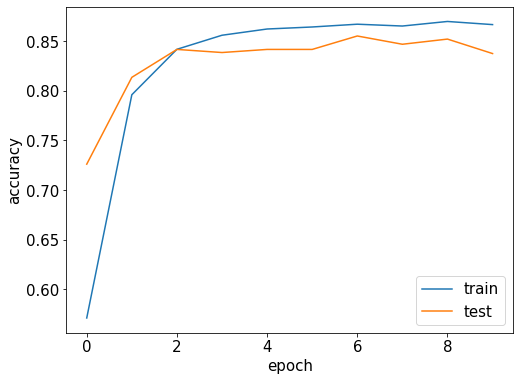

In [9]:
DEVICE_STATES = import_data_from_csv('learning_curve_vinod.csv')
model, test_accuracy_ls_mem, train_accuracy_ls_mem = run_RNN_simulation(save_results_input=True,
            num_epochs_input=10, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.01,
            device_variation_stddev_input=0.01,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0)

plot_figure(train_accuracy_ls_mem, test_accuracy_ls_mem)

Training the 1th epoch!
782/782 [==============================] - 372s 471ms/step - loss: 0.6440 - accuracy: 0.5563 - val_loss: 0.5166 - val_accuracy: 0.7219


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211055537_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211055537_10/assets


Save results in file model_20220211055537_10 successfully!

Training the 2th epoch!
782/782 [==============================] - 366s 467ms/step - loss: 0.4139 - accuracy: 0.8144 - val_loss: 0.3889 - val_accuracy: 0.8260


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211060214_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211060214_10/assets


Save results in file model_20220211060214_10 successfully!

Training the 3th epoch!
782/782 [==============================] - 364s 464ms/step - loss: 0.3450 - accuracy: 0.8535 - val_loss: 0.3689 - val_accuracy: 0.8281


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211060830_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211060830_10/assets


Save results in file model_20220211060830_10 successfully!

Training the 4th epoch!
782/782 [==============================] - 368s 470ms/step - loss: 0.3232 - accuracy: 0.8637 - val_loss: 0.3482 - val_accuracy: 0.8500


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211061502_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211061502_10/assets


Save results in file model_20220211061502_10 successfully!

Training the 5th epoch!
782/782 [==============================] - 362s 463ms/step - loss: 0.3148 - accuracy: 0.8678 - val_loss: 0.3459 - val_accuracy: 0.8552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211062135_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211062135_10/assets


Save results in file model_20220211062135_10 successfully!

Training the 6th epoch!
782/782 [==============================] - 370s 472ms/step - loss: 0.3107 - accuracy: 0.8698 - val_loss: 0.3405 - val_accuracy: 0.8510


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211062808_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211062808_10/assets


Save results in file model_20220211062808_10 successfully!

Training the 7th epoch!
782/782 [==============================] - 370s 473ms/step - loss: 0.3072 - accuracy: 0.8722 - val_loss: 0.3533 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211063428_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211063428_10/assets


Save results in file model_20220211063428_10 successfully!

Training the 8th epoch!
782/782 [==============================] - 368s 470ms/step - loss: 0.3067 - accuracy: 0.8718 - val_loss: 0.3449 - val_accuracy: 0.8562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211064101_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211064101_10/assets


Save results in file model_20220211064101_10 successfully!

Training the 9th epoch!
782/782 [==============================] - 378s 483ms/step - loss: 0.3044 - accuracy: 0.8728 - val_loss: 0.3377 - val_accuracy: 0.8562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211064719_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211064719_10/assets


Save results in file model_20220211064719_10 successfully!

Training the 10th epoch!
782/782 [==============================] - 373s 476ms/step - loss: 0.3019 - accuracy: 0.8744 - val_loss: 0.3463 - val_accuracy: 0.8583


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211065348_10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220211065348_10/assets


Save results in file model_20220211065348_10 successfully!



INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/final_model__10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/final_model__10/assets


Save results in file final_model__10 successfully!



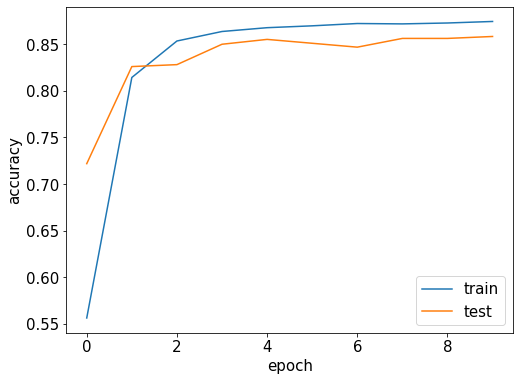

In [10]:
# pure algorithm 
model, test_accuracy_ls, train_accuracy_ls = run_RNN_simulation(save_results_input=True,
            num_epochs_input=10, 
            hardware_simulation_input=False, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.01,
            device_variation_stddev_input=0.01,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0)

plot_figure(train_accuracy_ls, test_accuracy_ls)

In [ ]:
DEVICE_STATES = import_data_from_csv('learning_curve_vinod.csv')
model, test_accuracy_ls_mem, train_accuracy_ls_mem = run_RNN_simulation(save_results_input=False,
            num_epochs_input=5, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0,
            device_variation_stddev_input=0,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0)

Training the 1th epoch!
782/782 [==============================] - 383s 484ms/step - loss: 0.6440 - accuracy: 0.5563 - val_loss: 0.5166 - val_accuracy: 0.7219
Training the 2th epoch!
782/782 [==============================] - 386s 493ms/step - loss: 0.4112 - accuracy: 0.8147 - val_loss: 0.3887 - val_accuracy: 0.8219
Training the 3th epoch!
782/782 [==============================] - 380s 485ms/step - loss: 0.3487 - accuracy: 0.8516 - val_loss: 0.3708 - val_accuracy: 0.8323
Training the 4th epoch!
782/782 [==============================] - 374s 478ms/step - loss: 0.3291 - accuracy: 0.8606 - val_loss: 0.3470 - val_accuracy: 0.8531
Training the 5th epoch!
782/782 [==============================] - 370s 473ms/step - loss: 0.3227 - accuracy: 0.8631 - val_loss: 0.3506 - val_accuracy: 0.8552


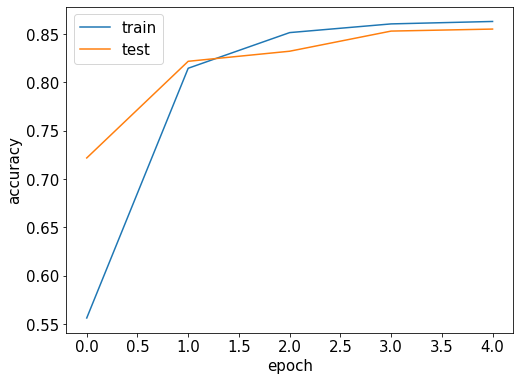

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_accuracy_ls_mem)), train_accuracy_ls_mem, label = 'train')
plt.plot(np.arange(len(test_accuracy_ls_mem)), test_accuracy_ls_mem, label = 'test')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("epoch", fontsize=15)
plt.ylabel("accuracy", fontsize=15)
plt.show()

In [ ]:
DEVICE_STATES = import_data_from_csv('learning_curve_vinod.csv')
model, test_accuracy_ls_mem, train_accuracy_ls_mem = run_RNN_simulation(save_results_input=False,
            num_epochs_input=5, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.01,
            device_variation_stddev_input=0.01,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0)

Training the 1th epoch!
782/782 [==============================] - 403s 510ms/step - loss: 0.6440 - accuracy: 0.5563 - val_loss: 0.5166 - val_accuracy: 0.7219
Training the 2th epoch!
782/782 [==============================] - 366s 467ms/step - loss: 0.4190 - accuracy: 0.8059 - val_loss: 0.3868 - val_accuracy: 0.8250
Training the 3th epoch!
782/782 [==============================] - 377s 482ms/step - loss: 0.3462 - accuracy: 0.8533 - val_loss: 0.3725 - val_accuracy: 0.8313
Training the 4th epoch!
782/782 [==============================] - 373s 477ms/step - loss: 0.3270 - accuracy: 0.8618 - val_loss: 0.3499 - val_accuracy: 0.8479
Training the 5th epoch!
782/782 [==============================] - 368s 470ms/step - loss: 0.3188 - accuracy: 0.8650 - val_loss: 0.3472 - val_accuracy: 0.8542


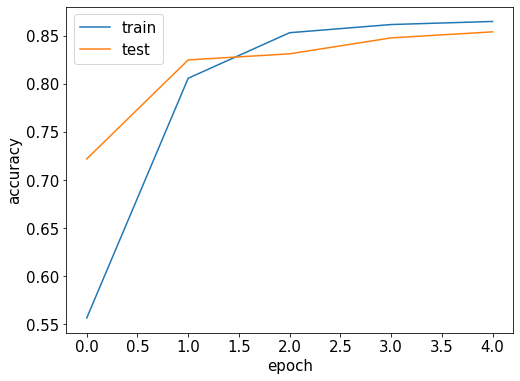

In [ ]:
train_accuracy_ls_mem_1 = [0.5563, 0.8059, 0.8533, 0.8618, 0.8650]
test_accuracy_ls_mem_1 = [0.7219, 0.8250, 0.8313, 0.8479, 0.8542]
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_accuracy_ls_mem_1)), train_accuracy_ls_mem_1, label = 'train')
plt.plot(np.arange(len(test_accuracy_ls_mem_1)), test_accuracy_ls_mem_1, label = 'test')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("epoch", fontsize=15)
plt.ylabel("accuracy", fontsize=15)
plt.show()

In [ ]:
DEVICE_STATES = import_data_from_csv('/content/drive/MyDrive/learning_curve_vinod.csv')
model, test_accuracy_ls_mem, train_accuracy_ls_mem = run_MLP_simulation(save_results_input=True,
            num_epochs_input=10, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.1,
            device_variation_stddev_input=0.1,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0)

Training the 0th epoch!
391/391 [==============================] - 445s 1s/step - loss: 0.6525 - accuracy: 0.5634 - val_loss: 0.5316 - val_accuracy: 0.7292


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!

Training the 1th epoch!
391/391 [==============================] - 437s 1s/step - loss: 0.6567 - accuracy: 0.5486 - val_loss: 0.5703 - val_accuracy: 0.6604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!

Training the 2th epoch!
391/391 [==============================] - 437s 1s/step - loss: 0.6047 - accuracy: 0.6386 - val_loss: 0.5472 - val_accuracy: 0.6875


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!

Training the 3th epoch!
391/391 [==============================] - 445s 1s/step - loss: 0.6186 - accuracy: 0.6269 - val_loss: 0.5339 - val_accuracy: 0.7198


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!

Training the 4th epoch!
391/391 [==============================] - 440s 1s/step - loss: 0.5942 - accuracy: 0.6770 - val_loss: 0.5599 - val_accuracy: 0.7042


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!

Training the 5th epoch!
391/391 [==============================] - 439s 1s/step - loss: 0.6098 - accuracy: 0.6681 - val_loss: 0.5840 - val_accuracy: 0.6615


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!

Training the 6th epoch!
391/391 [==============================] - 437s 1s/step - loss: 0.6307 - accuracy: 0.6410 - val_loss: 0.5953 - val_accuracy: 0.6646


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!

Training the 7th epoch!
391/391 [==============================] - 438s 1s/step - loss: 0.6374 - accuracy: 0.6403 - val_loss: 0.6075 - val_accuracy: 0.6859


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!

Training the 8th epoch!
391/391 [==============================] - 437s 1s/step - loss: 0.7056 - accuracy: 0.5786 - val_loss: 0.6753 - val_accuracy: 0.5615


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!

Training the 9th epoch!
391/391 [==============================] - 436s 1s/step - loss: 0.6908 - accuracy: 0.5636 - val_loss: 0.6763 - val_accuracy: 0.5865


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114194254 10/assets


Ssve results in file model_20220114194254 10 successfully!



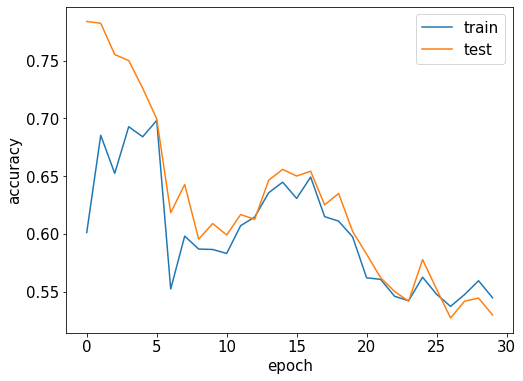

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_accuracy_ls_mem)), train_accuracy_ls_mem, label = 'train')
plt.plot(np.arange(len(test_accuracy_ls_mem)), test_accuracy_ls_mem, label = 'test')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("epoch", fontsize=15)
plt.ylabel("accuracy", fontsize=15)
plt.show()

In [ ]:
model, test_accuracy_ls, train_accuracy_ls = run_MLP_simulation(save_results_input=True,
            num_epochs_input=20, 
            hardware_simulation_input=False, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.1,
            device_variation_stddev_input=0.1,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0)

391/391 [==============================] - 437s 1s/step - loss: 0.6525 - accuracy: 0.5634 - val_loss: 0.5316 - val_accuracy: 0.7292


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 433s 1s/step - loss: 0.4437 - accuracy: 0.8015 - val_loss: 0.4076 - val_accuracy: 0.7995


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 434s 1s/step - loss: 0.3560 - accuracy: 0.8457 - val_loss: 0.3537 - val_accuracy: 0.8438


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 433s 1s/step - loss: 0.3300 - accuracy: 0.8606 - val_loss: 0.3462 - val_accuracy: 0.8505


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 438s 1s/step - loss: 0.3184 - accuracy: 0.8661 - val_loss: 0.3327 - val_accuracy: 0.8578


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 438s 1s/step - loss: 0.3131 - accuracy: 0.8680 - val_loss: 0.3364 - val_accuracy: 0.8490


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 440s 1s/step - loss: 0.3086 - accuracy: 0.8709 - val_loss: 0.3267 - val_accuracy: 0.8573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 434s 1s/step - loss: 0.3075 - accuracy: 0.8716 - val_loss: 0.3283 - val_accuracy: 0.8573


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 441s 1s/step - loss: 0.3055 - accuracy: 0.8717 - val_loss: 0.3300 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 443s 1s/step - loss: 0.3034 - accuracy: 0.8735 - val_loss: 0.3274 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 444s 1s/step - loss: 0.3047 - accuracy: 0.8732 - val_loss: 0.3251 - val_accuracy: 0.8589


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 439s 1s/step - loss: 0.3012 - accuracy: 0.8742 - val_loss: 0.3273 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 444s 1s/step - loss: 0.2994 - accuracy: 0.8763 - val_loss: 0.3260 - val_accuracy: 0.8568


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 446s 1s/step - loss: 0.2997 - accuracy: 0.8745 - val_loss: 0.3215 - val_accuracy: 0.8620


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 441s 1s/step - loss: 0.2979 - accuracy: 0.8764 - val_loss: 0.3384 - val_accuracy: 0.8552


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 439s 1s/step - loss: 0.2980 - accuracy: 0.8759 - val_loss: 0.3266 - val_accuracy: 0.8620


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 435s 1s/step - loss: 0.2969 - accuracy: 0.8776 - val_loss: 0.3216 - val_accuracy: 0.8604


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 442s 1s/step - loss: 0.2930 - accuracy: 0.8775 - val_loss: 0.3242 - val_accuracy: 0.8620


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 437s 1s/step - loss: 0.2946 - accuracy: 0.8775 - val_loss: 0.3203 - val_accuracy: 0.8609


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


391/391 [==============================] - 446s 1s/step - loss: 0.2887 - accuracy: 0.8792 - val_loss: 0.3250 - val_accuracy: 0.8562


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RNN_memtrainsistor_ckpts/model_20220114164037 20/assets


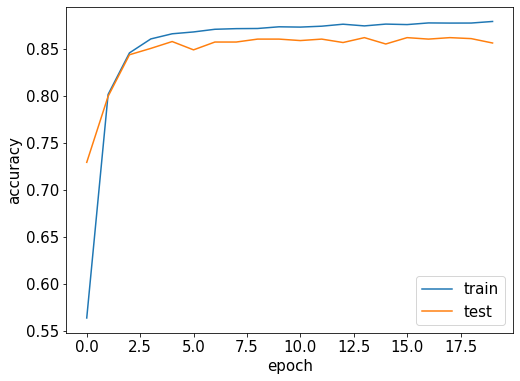

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(train_accuracy_ls)), train_accuracy_ls, label = 'train')
plt.plot(np.arange(len(test_accuracy_ls)), test_accuracy_ls, label = 'test')
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("epoch", fontsize=15)
plt.ylabel("accuracy", fontsize=15)
plt.show()

In [ ]:
np.arange(3)

array([0, 1, 2])

In [ ]:
DEVICE_STATES = import_data_from_csv('learning_curve_vinod.csv')
try:
  model = tf.keras.models.load_model('saved_model/my_model')
except:
  model = run_MLP_simulation(save_results_input=True,
            num_epochs_input=3, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.1,
            device_variation_stddev_input=0.1,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0)

391/391 [==============================] - 290s 740ms/step - loss: 0.6189 - accuracy: 0.6175 - val_loss: 0.5749 - val_accuracy: 0.6604


In [ ]:
DEVICE_STATES = import_data_from_csv('learning_curve_vinod.csv')
for i in range(5):
  model = run_MLP_simulation(save_results_input=False,
            num_epochs_input=1, 
            hardware_simulation_input=True, 
            device_states_input=DEVICE_STATES,
            read_noise_mean_input=0,
            read_noise_stddev_input=0.1,
            device_variation_stddev_input=0.1,
            device_stuck_on_prob_input=0,
            device_stuck_off_prob_input=0)

###**Old codes for CV**

In [ ]:
# need to upgrade to tf 2.7.0

def run_MLP_simulation(save_results_input = False,
                       num_epochs_input=50, 
                       hardware_simulation_input=False, 
                       device_states_input=False,
                       read_noise_mean_input=0,
                       read_noise_stddev_input=0,
                       device_variation_stddev_input=0,
                       device_stuck_on_prob_input=0,
                       device_stuck_off_prob_input=0):
    
    
    tf.compat.v1.disable_v2_behavior() # disable v2 behavior
    
    ###################### USER DEFINED PARAMETERS FOR SIMULATION
    # whether or not to save results
    SAVE_RESULTS = save_results_input
    
    # number of epochs to test
    NUM_EPOCHS = num_epochs_input

    # flag which determines whether this is a hardware simulation or purely software
    HARDWARE_SIMULATION = hardware_simulation_input

    # parameter set by user that gives all the possible normalized weight states
    # assumes (1) discrete number of states that are normalized 
    #         (2) states are set by two synaptic devices such that weight = weight_p - weight_m
    #         (3) because of (2), weights can vary from [-1,1]
    # user input = a 1D numpy array with values from [-1, 1]
    DEVICE_STATES = device_states_input


    # parameters for simulating read noise
    # user input = read noise mean and standard dev assuming a normal noise function
    READ_NOISE_MEAN = read_noise_mean_input
    READ_NOISE_STDDEV = read_noise_stddev_input

    # parameter for simulating device-to-device variation
    # user input =  standard deviation of conductances
    DEVICE_VARIATION_STDDEV = device_variation_stddev_input

    # parameter for simulating devices that get stuck on Gmax or Gmin states from the start
    # user input = probability for a device to get stuck
    # What is G?
    DEVICE_STUCK_ON_PROB = device_stuck_on_prob_input
    DEVICE_STUCK_OFF_PROB = device_stuck_off_prob_input

    
    
    ###################### SIM PARAMETERS
    n_inputs = 28*28  # MNIST
    n_hidden1 = 300 # neurons in 1st hidden layers
    n_outputs = 10 # neurons in output layer
    learning_rate = 0.1#0.01 # grad descent
    initializer_stddev = 0.2 # standar deviation of initialized random weights
    n_epochs = NUM_EPOCHS # number of epochs to test
    batch_size = 50 # batch size before tuning weights in grad descent

    # What are the possible values of DEVICE_STATES?
    g_min_value = np.min(np.abs(DEVICE_STATES))
    g_max_value = np.max(np.abs(DEVICE_STATES))
    
    
    
    
    ###################### FUNCTIONS

    # to make this notebook's output stable across runs
    def reset_graph(seed=42):
        #tf.reset_default_graph() # Why reset_default_graph()? helpful in testing process?
        tf.compat.v1.reset_default_graph
        tf.compat.v1.set_random_seed(seed)
        np.random.seed(seed)

    # will create matrix to simulate device-to-device variation by creating clipping the weights
    # will also simulate devices being stuck-on-open and stuck-on-close 
    # What is wp, wm, and how do them relate to g?
    def initialize_variation_stuck_mat(shape):

        # VARIATION
        wp_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is around 1
        wp_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is around 0

        wm_max = np.ones(shape=shape) - np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # max. is around 1
        wm_min = np.zeros(shape=shape) + np.abs(np.random.normal(0, DEVICE_VARIATION_STDDEV, shape)) # min. is around 0

        # STUCK
        stuck_prob = [DEVICE_STUCK_OFF_PROB, 1 - DEVICE_STUCK_ON_PROB - DEVICE_STUCK_OFF_PROB, DEVICE_STUCK_ON_PROB]
        w_p_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob)
        w_m_stuck = np.random.choice([-1, 0, 1], size=shape, p=stuck_prob)

        # if device is stuck OFF
        wp_max = wp_max + (w_p_stuck == -1) * (wp_min - wp_max)
        wm_max = wm_max + (w_m_stuck == -1) * (wm_min - wm_max)

        # if device is stuck ON
        wp_min = wp_min + (w_p_stuck == 1) * (wp_max - wp_min)
        wm_min = wm_min + (w_m_stuck == 1) * (wm_max - wm_min)


        # PUTTING TOGETHER CLIPPING MATRIX
        lower_lim = np.clip(wp_min - wm_max, -g_max_value, -g_min_value)
        upper_lim = np.clip(wp_max - wm_min, g_min_value, g_max_value)

        print('Lower lim: ' + str(lower_lim))
        print('Upper lim: ' + str(upper_lim))

        return [lower_lim, upper_lim]


    # weight update with a discrete number of states and (optional) add read noise
    def discrete_weight_update(value, read_noise_mean=0, read_noise_stddev=0):
        if read_noise_stddev != 0:
            value += np.random.normal(read_noise_mean, read_noise_stddev)
        absolute_difference_function = lambda list_value : abs(list_value - value)
        return min(DEVICE_STATES, key=absolute_difference_function)
    v_discrete_weight_update = np.vectorize(discrete_weight_update)



    # function puts together all the parts
    # 1. Device variation
    # 2. Stuck-on/off 
    # 3. Discrete number of weight states
    # Input = software weights matrix, Output = hardware weights matrix
    def simulate_hardware_weight_update(weights_mat, var_stuck_mat):

        # initialize variation and stuck matrix if not initialized
        if type(var_stuck_mat) is not np.ndarray:
            var_stuck_mat = initialize_variation_stuck_mat(weights_mat.shape)

        # simulate weight variation and stuck on open/close
        weights_mat = weights_mat.clip(var_stuck_mat[0], var_stuck_mat[1])

        # simulate discrete states
        weights_mat = v_discrete_weight_update(weights_mat, read_noise_mean = READ_NOISE_MEAN,
                                  read_noise_stddev = READ_NOISE_STDDEV)

        return weights_mat
    
    
    ###################### MLP SIM SETUP
    # reset default tf graph before running sim
    reset_graph()

    # get data, format
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    #X_valid, X_train = X_train[:5000], X_train[5000:]
    #y_valid, y_train = y_train[:5000], y_train[5000:]


    # define input and output placeholder variables
    X = tf.compat.v1.placeholder(tf.float32, shape=(None, n_inputs), name="X") # input
    y = tf.compat.v1.placeholder(tf.int32, shape=(None), name="y") # output

    # define NN layers
    # tf.name_scope similar to namespace in C++, so that variable logits -> dnn/logits
    with tf.name_scope("dnn"): 
        initiliazer = tf.truncated_normal_initializer(stddev = initializer_stddev)
        hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu, 
                                  kernel_initializer=initiliazer, bias_initializer=initiliazer)
        logits = tf.layers.dense(hidden1, n_outputs, name="outputs",
                                 kernel_initializer=initiliazer, bias_initializer=initiliazer)
        y_proba = tf.nn.softmax(logits)

        #embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        #gru = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        #dense = tf.keras.layers.Dense(vocab_size)

    # define loss
    with tf.name_scope("loss"): 
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

    # define training
    with tf.name_scope("train"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

    # define recognition rate eval op
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    # define weight update ops
    var_stuck_mat = [False, False, False, False]
    weights = [0,0,0,0]
    new_weights = [0,0,0,0]
    weight_update_op = [0,0,0,0]
    with tf.name_scope("weight_update"):
        weight_layers = ["hidden1/kernel:0", "hidden1/bias:0", "outputs/kernel:0", "outputs/bias:0"]
        for i, name in enumerate(weight_layers):
            weights[i] = [v for v in tf.trainable_variables() if v.name == name][0]
            new_weights[i] = tf.placeholder(tf.float32, name="new_weights"+name.replace("/","-").replace(":","-"))
            weight_update_op[i] = tf.assign(weights[i], new_weights[i])
    
    
    
    
    ###################### MLP SIM RUN
    epoch_ls = []
    recognition_rate_ls = []
    start_time = time.time()
    start_datetime  = datetime.utcnow().strftime("%Y%m%d%H%M%S")

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

    weights_before = False
    weights_after = False

    def shuffle_batch(X, y, batch_size):
        rnd_idx = np.random.permutation(len(X)) # permute - 改变序列
        n_batches = len(X) // batch_size 
        for batch_idx in np.array_split(rnd_idx, n_batches): # split rnd_idx into n_batches indexes
          X_batch, y_batch = X[batch_idx], y[batch_idx]
          yield X_batch, y_batch

    with tf.compat.v1.Session() as sess:
        init.run()

        for epoch in range(n_epochs):
            for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

            if HARDWARE_SIMULATION:
                ###### WEIGHT UPDATE  
                # simulate hardware by updating weights
                # includes discrete number of weight states

                # the code below only updates hidden1/kernel:0 weights

                # get weights
                #weights_temp = [v for v in tf.trainable_variables() if v.name == "hidden1/bias:0"][0]
                #weights_before = weights_temp.eval(session=sess)


                # simulate hardware weight update
                #new_weights_mat = simulate_hardware_weight_update(weights_mat, var_stuck_mat)

                # update weights to hardware simulated weights

                for i, weight in enumerate(weights):

                    weight = weight.eval(session=sess)
                    # !!! - where memtransistor works
                    new_weights_mat = simulate_hardware_weight_update(weight, var_stuck_mat[i]) 
                    weight_update_op[i].eval(feed_dict={new_weights[i]: new_weights_mat})


                ###### end of WEIGHT UPDATE



            # test accuracy
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Batch accuracy:", acc_batch, "Test accuracy:", acc_valid)
            
            # save to list
            epoch_ls.append(epoch)
            recognition_rate_ls.append(acc_valid)

            #weights_temp = [v for v in tf.trainable_variables() if v.name == "hidden1/bias:0"][0]
            #weights_after = weights_temp.eval(session=sess)    


        # save results
        if SAVE_RESULTS:
            save_path = "./MLP_sim_results/MLP_sim_" + start_datetime + "/model_" + start_datetime
            save_path = saver.save(sess, save_path + ".ckpt")
    
    # print out duration
    print("--- %0.2f seconds ---" % (time.time() - start_time))
    
    # save all results, including testing parameters and data
    if SAVE_RESULTS:
        save_path = "./MLP_sim_results/MLP_sim_" + start_datetime + "/model_" + start_datetime

        data_df = pd.DataFrame({"Epoch": epoch_ls, "Recognition Rate": recognition_rate_ls})
        data_df.to_csv(save_path + "_data.csv", index=False,)

        with open(save_path + "_meta.txt", "w") as text_file:
            print("---------- User input parameters -------------", file=text_file)
            print("Simulation start time: {}".format(start_datetime), file=text_file)
            print("Duration: {}".format(time.time() - start_time), file=text_file)
            print("Epochs: {}".format(num_epochs_input), file=text_file)
            print("Hardware simulation?: {}".format(hardware_simulation_input), file=text_file)
            print("Read noise - mean: {}".format(read_noise_mean_input), file=text_file)
            print("Read noise - standard deviation: {}".format(read_noise_stddev_input), file=text_file)
            print("Device variation - standard deviation: {}".format(device_variation_stddev_input), file=text_file)
            print("Device stuck on probability: {}".format(device_stuck_on_prob_input), file=text_file)
            print("Device stuck off probability: {}".format(device_stuck_off_prob_input), file=text_file)
            print("Device states used: {}".format(device_states_input), file=text_file)

            print("---------- Simulation parameters -------------", file=text_file)
            print("Number of inputs: {}".format(n_inputs), file=text_file)
            print("Layers: {}".format(weight_layers), file=text_file)
            print("Hidden1 # of neurons: {}".format(n_hidden1), file=text_file)
            print("Outputs # of neurons: {}".format(n_outputs), file=text_file)
            print("Learning rate: {}".format(learning_rate), file=text_file)
            print("Initializer standad dev: {}".format(initializer_stddev), file=text_file)
            print("Batch size: {}".format(batch_size), file=text_file)


# imports data from single column CSV file with possible current/conductance states
# return numpy array of approximate states possible using this hardware
# this import method is not generalized, but fine-tuned to Vinod's devices
def import_data_from_csv(filename):
    # import data
    imported_device_states = np.genfromtxt(filename, delimiter=',')[1:]

    # since data is in ~1 nA, assume maximum precision is ~1 pA
    # this will make some states redundant
    imported_device_states = np.unique(np.round(np.sort(imported_device_states), decimals=3))

    # calculate device states possible
    device_states = np.array([])
    for i, value in enumerate(imported_device_states):
        if i+1 > len(imported_device_states):
            break
        temp_ls = value - imported_device_states
        device_states = np.append(device_states, temp_ls)


    # normalize to -1 to 1
    device_states = np.unique(np.sort(device_states))
    device_states = device_states / np.abs(device_states).max()

    # given the large number of states, we can assume some states are almost equivalent
    # moreover, once the number of states is > 100, the discreteness doesnt matter
    # for simplicity in the simulations, we will simply  round to 2 digits of the calculated states
    device_states = np.round(device_states, decimals = 2)
    device_states = np.unique(np.sort(device_states))
    
    return device_states


In [ ]:
# mock simulation using np.arange for device states
for i in range(5):
    run_MLP_simulation(num_epochs_input = 100, 
                       hardware_simulation_input = False, 
                       device_states_input = False,
                       read_noise_mean_input = 0.0,
                       read_noise_stddev_input = 0.0,
                       device_variation_stddev_input = 0.0,
                       device_stuck_on_prob_input = 0.0,
                       device_stuck_off_prob_input = 0.0,
                       save_results_input = True)

Instructions for updating:
non-resource variables are not supported in the long term


AttributeError: ignored

In [ ]:
# run hardware sim 4 times
for i in range(4):
    imported_device_states = import_data_from_csv(filename='learning_curve_vinod.csv')
    run_MLP_simulation(num_epochs_input = 100, 
                       hardware_simulation_input = True, 
                       device_states_input = imported_device_states,
                       read_noise_mean_input = 0.0,
                       read_noise_stddev_input = 0.1,
                       device_variation_stddev_input = 0.0,
                       device_stuck_on_prob_input = 0.00,
                       device_stuck_off_prob_input = 0.00,
                       save_results_input = True)

0 Batch accuracy: 0.72 Test accuracy: 0.6556
1 Batch accuracy: 0.6 Test accuracy: 0.5914
2 Batch accuracy: 0.7 Test accuracy: 0.7075
3 Batch accuracy: 0.5 Test accuracy: 0.5555
4 Batch accuracy: 0.82 Test accuracy: 0.7896
5 Batch accuracy: 0.76 Test accuracy: 0.7968
6 Batch accuracy: 0.8 Test accuracy: 0.776
7 Batch accuracy: 0.82 Test accuracy: 0.7581
8 Batch accuracy: 0.9 Test accuracy: 0.8142
9 Batch accuracy: 0.6 Test accuracy: 0.6915
10 Batch accuracy: 0.78 Test accuracy: 0.8267
11 Batch accuracy: 0.9 Test accuracy: 0.8334
12 Batch accuracy: 0.84 Test accuracy: 0.8398
13 Batch accuracy: 0.82 Test accuracy: 0.8183
14 Batch accuracy: 0.8 Test accuracy: 0.843
15 Batch accuracy: 0.92 Test accuracy: 0.846
16 Batch accuracy: 0.78 Test accuracy: 0.826
17 Batch accuracy: 0.82 Test accuracy: 0.8299
18 Batch accuracy: 0.84 Test accuracy: 0.8476
19 Batch accuracy: 0.86 Test accuracy: 0.8514
20 Batch accuracy: 0.84 Test accuracy: 0.8119
21 Batch accuracy: 0.88 Test accuracy: 0.829
22 Batch ac

80 Batch accuracy: 0.9 Test accuracy: 0.8741
81 Batch accuracy: 0.8 Test accuracy: 0.8845
82 Batch accuracy: 0.94 Test accuracy: 0.8958
83 Batch accuracy: 0.88 Test accuracy: 0.9004
84 Batch accuracy: 0.9 Test accuracy: 0.8872
85 Batch accuracy: 0.82 Test accuracy: 0.8762
86 Batch accuracy: 0.9 Test accuracy: 0.885
87 Batch accuracy: 0.84 Test accuracy: 0.8654
88 Batch accuracy: 0.94 Test accuracy: 0.8849
89 Batch accuracy: 0.86 Test accuracy: 0.8693
90 Batch accuracy: 0.94 Test accuracy: 0.8902
91 Batch accuracy: 0.9 Test accuracy: 0.9053
92 Batch accuracy: 0.84 Test accuracy: 0.8824
93 Batch accuracy: 0.88 Test accuracy: 0.8821
94 Batch accuracy: 0.86 Test accuracy: 0.875
95 Batch accuracy: 0.98 Test accuracy: 0.8869
96 Batch accuracy: 0.92 Test accuracy: 0.8769
97 Batch accuracy: 0.82 Test accuracy: 0.8863
98 Batch accuracy: 0.88 Test accuracy: 0.8889
99 Batch accuracy: 0.94 Test accuracy: 0.8792
--- 3072.75 seconds ---
0 Batch accuracy: 0.72 Test accuracy: 0.6556
1 Batch accuracy: 

60 Batch accuracy: 0.88 Test accuracy: 0.8763
61 Batch accuracy: 0.88 Test accuracy: 0.8825
62 Batch accuracy: 0.94 Test accuracy: 0.8704
63 Batch accuracy: 0.88 Test accuracy: 0.8854
64 Batch accuracy: 0.84 Test accuracy: 0.8656
65 Batch accuracy: 0.9 Test accuracy: 0.8631
66 Batch accuracy: 0.92 Test accuracy: 0.8702
67 Batch accuracy: 0.92 Test accuracy: 0.8812
68 Batch accuracy: 0.9 Test accuracy: 0.8789
69 Batch accuracy: 0.9 Test accuracy: 0.8849
70 Batch accuracy: 0.88 Test accuracy: 0.8887
71 Batch accuracy: 0.88 Test accuracy: 0.8795
72 Batch accuracy: 0.9 Test accuracy: 0.8821
73 Batch accuracy: 0.94 Test accuracy: 0.8834
74 Batch accuracy: 0.9 Test accuracy: 0.8834
75 Batch accuracy: 0.94 Test accuracy: 0.884
76 Batch accuracy: 0.92 Test accuracy: 0.8814
77 Batch accuracy: 0.9 Test accuracy: 0.8798
78 Batch accuracy: 0.92 Test accuracy: 0.8825
79 Batch accuracy: 0.92 Test accuracy: 0.886
80 Batch accuracy: 0.9 Test accuracy: 0.8741
81 Batch accuracy: 0.8 Test accuracy: 0.884

In [ ]:
# run hardware sim 4 times
for i in range(4):
    imported_device_states = import_data_from_csv(filename='learning_curve_vinod.csv')
    run_MLP_simulation(num_epochs_input = 100, 
                       hardware_simulation_input = True, 
                       device_states_input = imported_device_states,
                       read_noise_mean_input = 0.0,
                       read_noise_stddev_input = 0.1,
                       device_variation_stddev_input = 0.0,
                       device_stuck_on_prob_input = 0.00,
                       device_stuck_off_prob_input = 0.00,
                       save_results_input = True)

0 Batch accuracy: 0.84 Test accuracy: 0.761
1 Batch accuracy: 0.86 Test accuracy: 0.8079
2 Batch accuracy: 0.88 Test accuracy: 0.8493
3 Batch accuracy: 0.84 Test accuracy: 0.823
4 Batch accuracy: 0.92 Test accuracy: 0.9038
5 Batch accuracy: 0.86 Test accuracy: 0.9098
6 Batch accuracy: 0.96 Test accuracy: 0.9185
7 Batch accuracy: 0.92 Test accuracy: 0.8956
8 Batch accuracy: 0.94 Test accuracy: 0.9088
9 Batch accuracy: 0.86 Test accuracy: 0.8886
10 Batch accuracy: 0.92 Test accuracy: 0.9233
11 Batch accuracy: 0.94 Test accuracy: 0.919
12 Batch accuracy: 0.84 Test accuracy: 0.917
13 Batch accuracy: 0.96 Test accuracy: 0.9239
14 Batch accuracy: 0.9 Test accuracy: 0.9272
15 Batch accuracy: 0.94 Test accuracy: 0.9344
16 Batch accuracy: 0.94 Test accuracy: 0.9288
17 Batch accuracy: 0.96 Test accuracy: 0.9197
18 Batch accuracy: 0.9 Test accuracy: 0.9308
19 Batch accuracy: 0.88 Test accuracy: 0.9271
20 Batch accuracy: 0.96 Test accuracy: 0.9229
21 Batch accuracy: 0.92 Test accuracy: 0.9356
22 B

79 Batch accuracy: 0.98 Test accuracy: 0.9432
80 Batch accuracy: 0.96 Test accuracy: 0.9453
81 Batch accuracy: 0.98 Test accuracy: 0.9485
82 Batch accuracy: 0.96 Test accuracy: 0.9482
83 Batch accuracy: 0.96 Test accuracy: 0.9417
84 Batch accuracy: 0.96 Test accuracy: 0.9472
85 Batch accuracy: 0.94 Test accuracy: 0.9449
86 Batch accuracy: 0.98 Test accuracy: 0.9481
87 Batch accuracy: 0.98 Test accuracy: 0.9496
88 Batch accuracy: 0.96 Test accuracy: 0.9505
89 Batch accuracy: 0.94 Test accuracy: 0.9453
90 Batch accuracy: 0.98 Test accuracy: 0.9494
91 Batch accuracy: 1.0 Test accuracy: 0.952
92 Batch accuracy: 0.96 Test accuracy: 0.9466
93 Batch accuracy: 0.94 Test accuracy: 0.9496
94 Batch accuracy: 0.94 Test accuracy: 0.944
95 Batch accuracy: 1.0 Test accuracy: 0.9475
96 Batch accuracy: 0.96 Test accuracy: 0.9516
97 Batch accuracy: 0.96 Test accuracy: 0.9425
98 Batch accuracy: 0.96 Test accuracy: 0.9457
99 Batch accuracy: 0.94 Test accuracy: 0.9451
--- 3079.70 seconds ---
0 Batch accura

58 Batch accuracy: 1.0 Test accuracy: 0.9432
59 Batch accuracy: 0.96 Test accuracy: 0.9416
60 Batch accuracy: 0.9 Test accuracy: 0.9444
61 Batch accuracy: 0.98 Test accuracy: 0.9438
62 Batch accuracy: 0.94 Test accuracy: 0.9366
63 Batch accuracy: 0.96 Test accuracy: 0.9392
64 Batch accuracy: 0.98 Test accuracy: 0.9374
65 Batch accuracy: 0.98 Test accuracy: 0.947
66 Batch accuracy: 0.98 Test accuracy: 0.9456
67 Batch accuracy: 0.98 Test accuracy: 0.9416
68 Batch accuracy: 0.94 Test accuracy: 0.9412
69 Batch accuracy: 0.92 Test accuracy: 0.9447
70 Batch accuracy: 0.94 Test accuracy: 0.9425
71 Batch accuracy: 0.96 Test accuracy: 0.9431
72 Batch accuracy: 0.96 Test accuracy: 0.9421
73 Batch accuracy: 0.96 Test accuracy: 0.9363
74 Batch accuracy: 0.96 Test accuracy: 0.9467
75 Batch accuracy: 0.98 Test accuracy: 0.9457
76 Batch accuracy: 0.94 Test accuracy: 0.9445
77 Batch accuracy: 0.98 Test accuracy: 0.9473
78 Batch accuracy: 0.96 Test accuracy: 0.9428
79 Batch accuracy: 0.98 Test accuracy

In [ ]:
imported_device_states = import_data_from_csv(filename='learning_curve_vinod.csv')


run_MLP_simulation(num_epochs_input = 100, 
                   hardware_simulation_input = True, 
                   device_states_input = imported_device_states,
                   read_noise_mean_input = 0.0,
                   read_noise_stddev_input = 0.1,
                   device_variation_stddev_input = 0.0,
                   device_stuck_on_prob_input = 0.00,
                   device_stuck_off_prob_input = 0.00,
                   save_results_input = True)


0 Batch accuracy: 0.72 Test accuracy: 0.6556
1 Batch accuracy: 0.6 Test accuracy: 0.5914
2 Batch accuracy: 0.7 Test accuracy: 0.7075
3 Batch accuracy: 0.5 Test accuracy: 0.5555
4 Batch accuracy: 0.82 Test accuracy: 0.7896
5 Batch accuracy: 0.76 Test accuracy: 0.7968
6 Batch accuracy: 0.8 Test accuracy: 0.776
7 Batch accuracy: 0.82 Test accuracy: 0.7581
8 Batch accuracy: 0.9 Test accuracy: 0.8142
9 Batch accuracy: 0.6 Test accuracy: 0.6915
10 Batch accuracy: 0.78 Test accuracy: 0.8267
11 Batch accuracy: 0.9 Test accuracy: 0.8334
12 Batch accuracy: 0.84 Test accuracy: 0.8398
13 Batch accuracy: 0.82 Test accuracy: 0.8183
14 Batch accuracy: 0.8 Test accuracy: 0.843
15 Batch accuracy: 0.92 Test accuracy: 0.846
16 Batch accuracy: 0.78 Test accuracy: 0.826
17 Batch accuracy: 0.82 Test accuracy: 0.8299
18 Batch accuracy: 0.84 Test accuracy: 0.8476
19 Batch accuracy: 0.86 Test accuracy: 0.8514
20 Batch accuracy: 0.84 Test accuracy: 0.8119
21 Batch accuracy: 0.88 Test accuracy: 0.829
22 Batch ac

In [ ]:
# mock simulation using np.arange for device states
run_MLP_simulation(num_epochs_input = 100, 
                   hardware_simulation_input = False, 
                   device_states_input = False,
                   read_noise_mean_input = 0.0,
                   read_noise_stddev_input = 0.0,
                   device_variation_stddev_input = 0.0,
                   device_stuck_on_prob_input = 0.0,
                   device_stuck_off_prob_input = 0.0,
                   save_results_input = True)

0 Batch accuracy: 0.88 Test accuracy: 0.8849
1 Batch accuracy: 0.86 Test accuracy: 0.9082
2 Batch accuracy: 0.92 Test accuracy: 0.9206
3 Batch accuracy: 0.96 Test accuracy: 0.9269
4 Batch accuracy: 1.0 Test accuracy: 0.9298
5 Batch accuracy: 0.98 Test accuracy: 0.9327
6 Batch accuracy: 0.96 Test accuracy: 0.9368
7 Batch accuracy: 0.96 Test accuracy: 0.9404
8 Batch accuracy: 0.96 Test accuracy: 0.944
9 Batch accuracy: 0.98 Test accuracy: 0.9456
10 Batch accuracy: 0.98 Test accuracy: 0.9467
11 Batch accuracy: 0.9 Test accuracy: 0.9497
12 Batch accuracy: 0.92 Test accuracy: 0.9499
13 Batch accuracy: 0.98 Test accuracy: 0.9533
14 Batch accuracy: 0.94 Test accuracy: 0.9533
15 Batch accuracy: 0.94 Test accuracy: 0.9553
16 Batch accuracy: 1.0 Test accuracy: 0.9558
17 Batch accuracy: 0.94 Test accuracy: 0.9566
18 Batch accuracy: 0.98 Test accuracy: 0.9581
19 Batch accuracy: 0.96 Test accuracy: 0.9574
20 Batch accuracy: 0.96 Test accuracy: 0.9579
21 Batch accuracy: 0.98 Test accuracy: 0.9595
22

# Results

## software only (~2 mins , 10 sec)
- Learning rate = 0.01
0 Batch accuracy: 0.88 Test accuracy: 0.8849
1 Batch accuracy: 0.86 Test accuracy: 0.9082
2 Batch accuracy: 0.92 Test accuracy: 0.9206
3 Batch accuracy: 0.96 Test accuracy: 0.9269
4 Batch accuracy: 1.0 Test accuracy: 0.9298
5 Batch accuracy: 0.98 Test accuracy: 0.9327
6 Batch accuracy: 0.96 Test accuracy: 0.9368
7 Batch accuracy: 0.96 Test accuracy: 0.9404
8 Batch accuracy: 0.96 Test accuracy: 0.944
9 Batch accuracy: 0.98 Test accuracy: 0.9456
10 Batch accuracy: 0.98 Test accuracy: 0.9467
11 Batch accuracy: 0.9 Test accuracy: 0.9497
12 Batch accuracy: 0.92 Test accuracy: 0.9499
13 Batch accuracy: 0.98 Test accuracy: 0.9533
14 Batch accuracy: 0.94 Test accuracy: 0.9533
15 Batch accuracy: 0.94 Test accuracy: 0.9553
16 Batch accuracy: 1.0 Test accuracy: 0.9558
17 Batch accuracy: 0.94 Test accuracy: 0.9566
18 Batch accuracy: 0.98 Test accuracy: 0.9581
19 Batch accuracy: 0.96 Test accuracy: 0.9574
20 Batch accuracy: 0.96 Test accuracy: 0.9579
21 Batch accuracy: 0.98 Test accuracy: 0.9595
22 Batch accuracy: 0.94 Test accuracy: 0.9607
23 Batch accuracy: 0.98 Test accuracy: 0.9607
24 Batch accuracy: 0.98 Test accuracy: 0.961
25 Batch accuracy: 0.98 Test accuracy: 0.9612
26 Batch accuracy: 1.0 Test accuracy: 0.9623
27 Batch accuracy: 1.0 Test accuracy: 0.9628
28 Batch accuracy: 1.0 Test accuracy: 0.9622
29 Batch accuracy: 0.98 Test accuracy: 0.9632
30 Batch accuracy: 0.98 Test accuracy: 0.9636
31 Batch accuracy: 1.0 Test accuracy: 0.9625
32 Batch accuracy: 0.92 Test accuracy: 0.9637
33 Batch accuracy: 0.96 Test accuracy: 0.9652
34 Batch accuracy: 0.96 Test accuracy: 0.9635
35 Batch accuracy: 0.96 Test accuracy: 0.9637
36 Batch accuracy: 0.98 Test accuracy: 0.9655
37 Batch accuracy: 1.0 Test accuracy: 0.9656
38 Batch accuracy: 1.0 Test accuracy: 0.9662
39 Batch accuracy: 0.98 Test accuracy: 0.9666
40 Batch accuracy: 1.0 Test accuracy: 0.966
41 Batch accuracy: 0.98 Test accuracy: 0.9665
42 Batch accuracy: 0.96 Test accuracy: 0.9666
43 Batch accuracy: 0.98 Test accuracy: 0.9681
44 Batch accuracy: 1.0 Test accuracy: 0.9677
45 Batch accuracy: 0.98 Test accuracy: 0.9666
46 Batch accuracy: 0.96 Test accuracy: 0.9675
47 Batch accuracy: 1.0 Test accuracy: 0.9675
48 Batch accuracy: 1.0 Test accuracy: 0.9682
49 Batch accuracy: 1.0 Test accuracy: 0.9683
--- 140.81 seconds ---

## software only (~30 secs)
- Learning rate = 0.1
0 Batch accuracy: 0.94 Test accuracy: 0.9427
1 Batch accuracy: 0.98 Test accuracy: 0.9556
2 Batch accuracy: 0.98 Test accuracy: 0.9635
3 Batch accuracy: 1.0 Test accuracy: 0.9665
4 Batch accuracy: 1.0 Test accuracy: 0.965
5 Batch accuracy: 1.0 Test accuracy: 0.9678
6 Batch accuracy: 1.0 Test accuracy: 0.9699
7 Batch accuracy: 1.0 Test accuracy: 0.9722
8 Batch accuracy: 1.0 Test accuracy: 0.9727
9 Batch accuracy: 1.0 Test accuracy: 0.9718
10 Batch accuracy: 1.0 Test accuracy: 0.9746
11 Batch accuracy: 0.98 Test accuracy: 0.9745
12 Batch accuracy: 1.0 Test accuracy: 0.9765
13 Batch accuracy: 1.0 Test accuracy: 0.9765
14 Batch accuracy: 1.0 Test accuracy: 0.9762
15 Batch accuracy: 1.0 Test accuracy: 0.9753
16 Batch accuracy: 1.0 Test accuracy: 0.9754
17 Batch accuracy: 1.0 Test accuracy: 0.977
18 Batch accuracy: 1.0 Test accuracy: 0.9756
19 Batch accuracy: 1.0 Test accuracy: 0.9768
20 Batch accuracy: 1.0 Test accuracy: 0.977

## hardware ON, but just discrete states (20) (~2 min, 13 s)
0 Batch accuracy: 0.92 Test accuracy: 0.933
1 Batch accuracy: 0.92 Test accuracy: 0.938
2 Batch accuracy: 0.94 Test accuracy: 0.9418
3 Batch accuracy: 0.98 Test accuracy: 0.9431
4 Batch accuracy: 0.94 Test accuracy: 0.942
5 Batch accuracy: 0.96 Test accuracy: 0.9401
6 Batch accuracy: 0.92 Test accuracy: 0.9405
7 Batch accuracy: 0.96 Test accuracy: 0.9417
8 Batch accuracy: 0.92 Test accuracy: 0.9422
9 Batch accuracy: 0.96 Test accuracy: 0.9402
10 Batch accuracy: 1.0 Test accuracy: 0.9405
11 Batch accuracy: 0.92 Test accuracy: 0.9405
12 Batch accuracy: 0.96 Test accuracy: 0.9416
13 Batch accuracy: 0.94 Test accuracy: 0.9415
14 Batch accuracy: 0.98 Test accuracy: 0.9417
15 Batch accuracy: 0.98 Test accuracy: 0.9415
16 Batch accuracy: 0.96 Test accuracy: 0.9422
17 Batch accuracy: 0.96 Test accuracy: 0.9422
18 Batch accuracy: 0.88 Test accuracy: 0.9425
19 Batch accuracy: 0.98 Test accuracy: 0.942

## hardware ON, but just discrete states (100) ( min,  s)
0 Batch accuracy: 0.94 Test accuracy: 0.941
1 Batch accuracy: 0.96 Test accuracy: 0.9539
2 Batch accuracy: 0.98 Test accuracy: 0.9604
3 Batch accuracy: 1.0 Test accuracy: 0.9651
4 Batch accuracy: 1.0 Test accuracy: 0.9664
5 Batch accuracy: 1.0 Test accuracy: 0.9679
6 Batch accuracy: 0.98 Test accuracy: 0.9671
7 Batch accuracy: 1.0 Test accuracy: 0.971
8 Batch accuracy: 0.98 Test accuracy: 0.9705
9 Batch accuracy: 1.0 Test accuracy: 0.9709
10 Batch accuracy: 1.0 Test accuracy: 0.9711
11 Batch accuracy: 0.98 Test accuracy: 0.971
12 Batch accuracy: 1.0 Test accuracy: 0.9704
13 Batch accuracy: 0.98 Test accuracy: 0.9706
14 Batch accuracy: 1.0 Test accuracy: 0.9729
15 Batch accuracy: 1.0 Test accuracy: 0.9724
16 Batch accuracy: 1.0 Test accuracy: 0.9736

## hardware ON with... (1 min 11s)
- 20 states
- readnoise = 0.0 +/- 0.2
- stuckon = stuckoff = 0.05
- device_var = 0.1
0 Batch accuracy: 0.4 Test accuracy: 0.3264
1 Batch accuracy: 0.44 Test accuracy: 0.4225
2 Batch accuracy: 0.52 Test accuracy: 0.4578
3 Batch accuracy: 0.52 Test accuracy: 0.4802
4 Batch accuracy: 0.64 Test accuracy: 0.6497
5 Batch accuracy: 0.58 Test accuracy: 0.6118
6 Batch accuracy: 0.46 Test accuracy: 0.551
7 Batch accuracy: 0.52 Test accuracy: 0.5524
--- 71.81 seconds ---

## hardware ON with... (1 min 3s)
- 20 states
- readnoise = 0.0 +/- 0.05
- stuckon = stuckoff = 0.05
- device_var = 0.1
0 Batch accuracy: 0.88 Test accuracy: 0.8143
1 Batch accuracy: 0.94 Test accuracy: 0.8872
2 Batch accuracy: 0.92 Test accuracy: 0.8669
3 Batch accuracy: 0.78 Test accuracy: 0.8651
4 Batch accuracy: 0.96 Test accuracy: 0.8995
5 Batch accuracy: 0.9 Test accuracy: 0.9091
6 Batch accuracy: 0.92 Test accuracy: 0.8873
7 Batch accuracy: 0.88 Test accuracy: 0.8694
--- 63.78 seconds ---


## hardware ON with... (17 mins)
- 100 states
- readnoise = 0.0 +/- 0.05
- stuckon = stuckoff = 0.05
- device_var = 0.1
0 Batch accuracy: 0.86 Test accuracy: 0.8376
1 Batch accuracy: 0.96 Test accuracy: 0.8902
2 Batch accuracy: 0.94 Test accuracy: 0.8869
3 Batch accuracy: 0.9 Test accuracy: 0.8921
4 Batch accuracy: 0.94 Test accuracy: 0.9196
5 Batch accuracy: 0.9 Test accuracy: 0.9166
6 Batch accuracy: 0.94 Test accuracy: 0.9174
7 Batch accuracy: 0.88 Test accuracy: 0.9134
8 Batch accuracy: 0.88 Test accuracy: 0.884
9 Batch accuracy: 0.88 Test accuracy: 0.9095
10 Batch accuracy: 0.92 Test accuracy: 0.913
11 Batch accuracy: 0.86 Test accuracy: 0.909
12 Batch accuracy: 0.94 Test accuracy: 0.9265
13 Batch accuracy: 0.9 Test accuracy: 0.901
14 Batch accuracy: 0.92 Test accuracy: 0.9157
15 Batch accuracy: 0.92 Test accuracy: 0.8996
16 Batch accuracy: 0.9 Test accuracy: 0.9165
17 Batch accuracy: 0.92 Test accuracy: 0.917
18 Batch accuracy: 0.96 Test accuracy: 0.926
19 Batch accuracy: 0.94 Test accuracy: 0.9229
20 Batch accuracy: 0.98 Test accuracy: 0.9061
21 Batch accuracy: 0.94 Test accuracy: 0.9252
22 Batch accuracy: 0.92 Test accuracy: 0.9188
23 Batch accuracy: 0.96 Test accuracy: 0.9229
24 Batch accuracy: 0.94 Test accuracy: 0.9326
25 Batch accuracy: 0.96 Test accuracy: 0.9163
26 Batch accuracy: 0.94 Test accuracy: 0.923
27 Batch accuracy: 0.92 Test accuracy: 0.9222
28 Batch accuracy: 0.94 Test accuracy: 0.926
29 Batch accuracy: 0.98 Test accuracy: 0.9132
30 Batch accuracy: 0.96 Test accuracy: 0.9141
31 Batch accuracy: 0.94 Test accuracy: 0.9229
32 Batch accuracy: 0.88 Test accuracy: 0.9223
33 Batch accuracy: 0.9 Test accuracy: 0.8704
34 Batch accuracy: 0.9 Test accuracy: 0.9216
35 Batch accuracy: 0.92 Test accuracy: 0.9069
36 Batch accuracy: 0.94 Test accuracy: 0.9095
37 Batch accuracy: 0.92 Test accuracy: 0.9306
38 Batch accuracy: 0.9 Test accuracy: 0.9147
39 Batch accuracy: 0.94 Test accuracy: 0.9339
40 Batch accuracy: 0.96 Test accuracy: 0.9148
41 Batch accuracy: 0.96 Test accuracy: 0.8807
42 Batch accuracy: 0.92 Test accuracy: 0.8752
43 Batch accuracy: 0.92 Test accuracy: 0.9108
44 Batch accuracy: 0.92 Test accuracy: 0.9234
45 Batch accuracy: 0.94 Test accuracy: 0.9276
46 Batch accuracy: 0.94 Test accuracy: 0.9113
47 Batch accuracy: 0.9 Test accuracy: 0.914
48 Batch accuracy: 0.98 Test accuracy: 0.9277
49 Batch accuracy: 0.9 Test accuracy: 0.9335
--- 995.70 seconds ---

## hardware ON with... (14 mins)
- 100 states
- readnoise = 0.0 +/- 0.00
- stuckon = stuckoff = 0.05
- device_var = 0.1

0 Batch accuracy: 0.92 Test accuracy: 0.9238
1 Batch accuracy: 0.92 Test accuracy: 0.9367
2 Batch accuracy: 0.96 Test accuracy: 0.9368
3 Batch accuracy: 0.96 Test accuracy: 0.9459
4 Batch accuracy: 0.98 Test accuracy: 0.9495
5 Batch accuracy: 0.98 Test accuracy: 0.9565
6 Batch accuracy: 0.9 Test accuracy: 0.9342
7 Batch accuracy: 0.98 Test accuracy: 0.9486
8 Batch accuracy: 0.96 Test accuracy: 0.9432
9 Batch accuracy: 0.96 Test accuracy: 0.948
10 Batch accuracy: 1.0 Test accuracy: 0.9513
11 Batch accuracy: 0.94 Test accuracy: 0.9572
12 Batch accuracy: 1.0 Test accuracy: 0.9436
13 Batch accuracy: 0.92 Test accuracy: 0.9293
14 Batch accuracy: 0.96 Test accuracy: 0.9586
15 Batch accuracy: 1.0 Test accuracy: 0.9583
16 Batch accuracy: 0.98 Test accuracy: 0.9644
17 Batch accuracy: 1.0 Test accuracy: 0.9469
18 Batch accuracy: 0.9 Test accuracy: 0.9589
19 Batch accuracy: 0.98 Test accuracy: 0.9617
20 Batch accuracy: 0.96 Test accuracy: 0.9519
21 Batch accuracy: 0.94 Test accuracy: 0.9536
22 Batch accuracy: 0.96 Test accuracy: 0.9654
23 Batch accuracy: 0.98 Test accuracy: 0.9594
24 Batch accuracy: 0.98 Test accuracy: 0.9655
25 Batch accuracy: 1.0 Test accuracy: 0.9624
26 Batch accuracy: 0.96 Test accuracy: 0.9626
27 Batch accuracy: 1.0 Test accuracy: 0.958
28 Batch accuracy: 1.0 Test accuracy: 0.9532
29 Batch accuracy: 1.0 Test accuracy: 0.9704
30 Batch accuracy: 0.98 Test accuracy: 0.9576
31 Batch accuracy: 1.0 Test accuracy: 0.9594
32 Batch accuracy: 0.98 Test accuracy: 0.9676
33 Batch accuracy: 1.0 Test accuracy: 0.9568
34 Batch accuracy: 1.0 Test accuracy: 0.97
35 Batch accuracy: 0.98 Test accuracy: 0.9625
36 Batch accuracy: 1.0 Test accuracy: 0.9638
37 Batch accuracy: 0.98 Test accuracy: 0.9559
38 Batch accuracy: 1.0 Test accuracy: 0.9564
39 Batch accuracy: 0.98 Test accuracy: 0.9416
40 Batch accuracy: 0.98 Test accuracy: 0.9536
41 Batch accuracy: 0.98 Test accuracy: 0.9669
42 Batch accuracy: 0.96 Test accuracy: 0.9723
43 Batch accuracy: 0.94 Test accuracy: 0.9654
44 Batch accuracy: 0.96 Test accuracy: 0.9631
45 Batch accuracy: 0.98 Test accuracy: 0.9669
46 Batch accuracy: 1.0 Test accuracy: 0.9717
47 Batch accuracy: 0.94 Test accuracy: 0.9653
48 Batch accuracy: 0.92 Test accuracy: 0.9347
49 Batch accuracy: 1.0 Test accuracy: 0.9634
--- 875.17 seconds ---



In [ ]:
weights_before

array([-0.00363304, -0.16495076, -0.00245212, -0.07429077, -0.0231128 ,
       -0.34697148,  0.3885961 ,  0.30065742,  0.22381195, -0.0381159 ,
        0.00310417,  0.08535535,  0.17385383,  0.30208942,  0.125374  ,
        0.00897076,  0.07525111, -0.29270896, -0.18102363,  0.06648245,
       -0.01434219, -0.12452476, -0.23496754,  0.24518795, -0.03454113,
        0.09062955,  0.05114428, -0.01170656,  0.31281415,  0.05068856,
       -0.07658286, -0.3558821 , -0.02831533,  0.29215947, -0.01215394,
        0.05968314,  0.26844263,  0.34673175,  0.00499299,  0.01214231,
       -0.26232064, -0.18391348, -0.30076265,  0.08745792,  0.04777403,
       -0.30305094,  0.33885407, -0.22074407, -0.01648456,  0.14930668,
       -0.10613731, -0.15380175,  0.04764128,  0.1736799 , -0.05961963,
       -0.23478894, -0.18598206, -0.05220306, -0.03114807,  0.04526016,
       -0.13837756,  0.17210205, -0.11568228, -0.06414939, -0.07839669,
       -0.31229424, -0.2896966 ,  0.03144627, -0.03642305, -0.16

In [ ]:
weights_after

array([-0. , -0.2, -0. , -0.1, -0. , -0.3,  0.4,  0.3,  0.2, -0. , -0. ,
        0.1,  0.2,  0.3,  0.1, -0. ,  0.1, -0.3, -0.2,  0.1, -0. , -0.1,
       -0.2,  0.2, -0. ,  0.1,  0.1, -0. ,  0.3,  0.1, -0.1, -0.4, -0. ,
        0.3, -0. ,  0.1,  0.3,  0.3, -0. , -0. , -0.3, -0.2, -0.3,  0.1,
       -0. , -0.3,  0.3, -0.2, -0. ,  0.1, -0.1, -0.2, -0. ,  0.2, -0.1,
       -0.2, -0.2, -0.1, -0. , -0. , -0.1,  0.2, -0.1, -0.1, -0.1, -0.3,
       -0.3, -0. , -0. , -0.2, -0. ,  0.2, -0. , -0.1, -0. ,  0.2, -0. ,
        0.1,  0.4, -0.1,  0.2, -0.1, -0.1, -0. ,  0.1,  0.2,  0.1, -0.4,
       -0. , -0.1,  0.1, -0.2,  0.1, -0.2, -0.2, -0.1, -0.1, -0. ,  0.1,
       -0.2,  0.1, -0.1, -0. , -0.4,  0.1, -0.3, -0.1,  0.2,  0.1, -0.1,
        0.3,  0.1,  0.3,  0.1,  0.1,  0.2, -0.3,  0.2, -0.2, -0. ,  0.1,
        0.2,  0.1,  0.1, -0.3, -0.1,  0.3, -0. , -0.2, -0.2,  0.1,  0.2,
       -0. ,  0.3, -0.3,  0.1,  0.2, -0.1, -0.2, -0.3,  0.1,  0.1, -0.3,
       -0. , -0. ,  0.1, -0. ,  0.1,  0.1,  0.3,  0

In [ ]:
AlexNet = maxpool lots of layers
Vggnet = after alexnet, less intensive convolutions; higher num of params and lower accuracy
Resnet = 
inception = best but lots improve